In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from scipy.sparse import csr_matrix

In [8]:
import os
print(os.getcwd())  # shows current working directory


C:\Users\yamun


In [9]:
import os
os.chdir(r"C:\Users\yamun\Downloads\music_recommender-master\music_recommender-master\collaborative_recommender_system")


In [12]:
!pip install fuzzywuzzy


In [14]:
!pip install python-Levenshtein


                                              0.0/100.4 kB ? eta -:--:--
                                              0.0/100.4 kB ? eta -:--:--
     ----                                     10.2/100.4 kB ? eta -:--:--
     ----                                     10.2/100.4 kB ? eta -:--:--
     -----------                           30.7/100.4 kB 262.6 kB/s eta 0:00:01
     -----------                           30.7/100.4 kB 262.6 kB/s eta 0:00:01
     ---------------                       41.0/100.4 kB 178.6 kB/s eta 0:00:01
     ----------------------                61.4/100.4 kB 217.9 kB/s eta 0:00:01
     ------------------------------        81.9/100.4 kB 254.2 kB/s eta 0:00:01
     ------------------------------------ 100.4/100.4 kB 274.9 kB/s eta 0:00:00
                                              0.0/1.6 MB ? eta -:--:--
                                              0.0/1.6 MB ? eta -:--:--
                                              0.0/1.6 MB ? eta -:--:--
     --      

In [15]:
from recommeders.knn_recommender import Recommender


In [17]:
import pandas as pd
import numpy as np

# Settings
num_users = 100
num_songs = 50

# Generate user IDs and song IDs
user_ids = [f'user_{i}' for i in range(1, num_users + 1)]
song_ids = [f'song_{i}' for i in range(1, num_songs + 1)]

# Generate listen counts randomly (between 1 and 20)
data = []
for user in user_ids:
    # Each user listens to a random number of songs
    listened_songs = np.random.choice(song_ids, size=np.random.randint(5, 15), replace=False)
    for song in listened_songs:
        listen_count = np.random.randint(1, 21)
        data.append({'user_id': user, 'song_id': song, 'listen_count': listen_count})

song_info = pd.DataFrame(data)

# Generate song metadata
song_actual = pd.DataFrame({
    'song_id': song_ids,
    'title': [f'Title {i}' for i in range(1, num_songs + 1)],
    'artist_name': [f'Artist {np.random.randint(1, 20)}' for _ in range(num_songs)]
})

# Merge to get full dataset
songs = pd.merge(song_info, song_actual, on='song_id', how='left')

print(songs.head())


  user_id  song_id  listen_count     title artist_name
0  user_1  song_23            17  Title 23   Artist 13
1  user_1  song_26             4  Title 26    Artist 3
2  user_1  song_46            16  Title 46   Artist 12
3  user_1  song_30             3  Title 30    Artist 3
4  user_1  song_43            20  Title 43   Artist 13


In [18]:
import pandas as pd

# 1. Create user-song matrix (rows = songs, columns = users, values = listen_count)
user_song_matrix = songs.pivot_table(index='song_id', columns='user_id', values='listen_count', fill_value=0)

# 2. Create decode_id_song dictionary (mapping song title -> song index in matrix)
# We need to map song titles to the row indices of user_song_matrix

# First, create a mapping from song_id to title
song_id_to_title = songs.drop_duplicates('song_id').set_index('song_id')['title'].to_dict()

# Now map the user_song_matrix index (song_id) to song titles, and then create a dict title -> row index
decode_id_song = {song_id_to_title[song_id]: idx for idx, song_id in enumerate(user_song_matrix.index)}

print("User-song matrix shape:", user_song_matrix.shape)
print("Sample decode_id_song entries:", list(decode_id_song.items())[:5])


User-song matrix shape: (50, 100)
Sample decode_id_song entries: [('Title 1', 0), ('Title 10', 1), ('Title 11', 2), ('Title 12', 3), ('Title 13', 4)]


In [19]:
songs.head()

,user_id,song_id,listen_count,title,artist_name
0,user_1,song_23,17,Title 23,Artist 13
1,user_1,song_26,4,Title 26,Artist 3
2,user_1,song_46,16,Title 46,Artist 12
3,user_1,song_30,3,Title 30,Artist 3
4,user_1,song_43,20,Title 43,Artist 13


In [20]:
songs.to_csv('songs.csv', index=False)

In [21]:
df_songs = pd.read_csv('songs.csv')

In [22]:
df_songs.head()

,user_id,song_id,listen_count,title,artist_name
0,user_1,song_23,17,Title 23,Artist 13
1,user_1,song_26,4,Title 26,Artist 3
2,user_1,song_46,16,Title 46,Artist 12
3,user_1,song_30,3,Title 30,Artist 3
4,user_1,song_43,20,Title 43,Artist 13


In [23]:
#Get total observations
print(f"There are {df_songs.shape[0]} observations in the dataset")

There are 912 observations in the dataset


In [24]:
df_songs.isnull().sum()

user_id         0
song_id         0
listen_count    0
title           0
artist_name     0
dtype: int64

In [25]:
df_songs.dtypes

user_id         object
song_id         object
listen_count     int64
title           object
artist_name     object
dtype: object

In [26]:
#Unique songs
unique_songs = df_songs['title'].unique().shape[0]
print(f"There are {unique_songs} unique songs in the dataset")

There are 50 unique songs in the dataset


In [27]:
#Unique artists
unique_artists = df_songs['artist_name'].unique().shape[0]
print(f"There are {unique_artists} unique artists in the dataset")

There are 19 unique artists in the dataset


In [28]:
#Unique users
unique_users = df_songs['user_id'].unique().shape[0]
print(f"There are {unique_users} unique users in the dataset")

There are 100 unique users in the dataset


In [29]:
#count how many rows we have by song, we show only the ten more popular songs 
ten_pop_songs = df_songs.groupby('title')['listen_count'].count().reset_index().sort_values(['listen_count', 'title'], ascending = [0,1])
ten_pop_songs['percentage']  = round(ten_pop_songs['listen_count'].div(ten_pop_songs['listen_count'].sum())*100, 2)

In [30]:
ten_pop_songs = ten_pop_songs[:10]
ten_pop_songs

,title,listen_count,percentage
14,Title 22,27,2.96
34,Title 40,27,2.96
44,Title 5,27,2.96
25,Title 32,24,2.63
27,Title 34,24,2.63
38,Title 44,24,2.63
30,Title 37,23,2.52
18,Title 26,22,2.41
21,Title 29,22,2.41
33,Title 4,22,2.41


In [31]:
labels = ten_pop_songs['title'].tolist()
counts = ten_pop_songs['listen_count'].tolist()

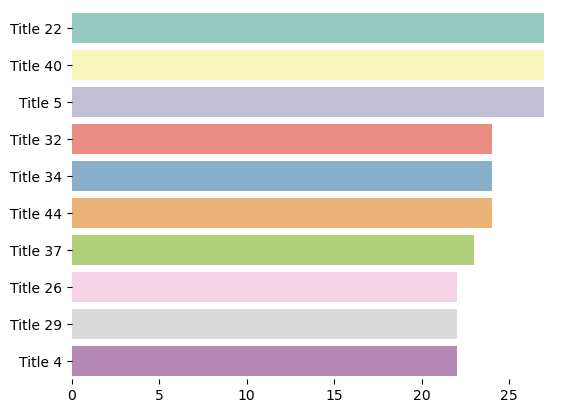

In [32]:
plt.figure()
sns.barplot(x=counts, y=labels, palette='Set3')
sns.despine(left=True, bottom=True)

In [33]:
#count how many rows we have by artist name, we show only the ten more popular artist 
ten_pop_artists  = df_songs.groupby(['artist_name'])['listen_count'].count().reset_index().sort_values(['listen_count', 'artist_name'], 
                                                                                                ascending = [0,1])

In [34]:
ten_pop_artists = ten_pop_artists[:10]
ten_pop_artists

,artist_name,listen_count
4,Artist 13,105
12,Artist 3,92
18,Artist 9,91
2,Artist 11,74
15,Artist 6,64
17,Artist 8,59
9,Artist 18,54
16,Artist 7,45
5,Artist 14,41
7,Artist 16,40


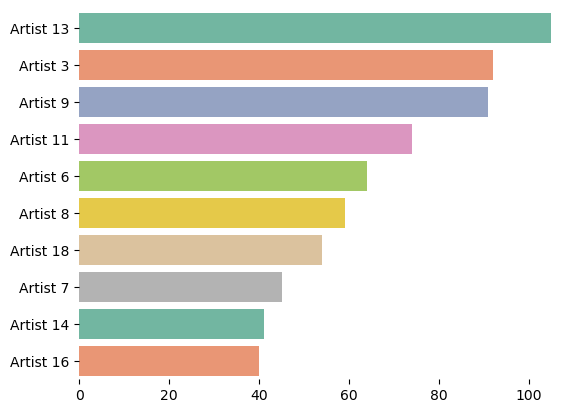

In [35]:
plt.figure()
labels = ten_pop_artists['artist_name'].tolist()
counts = ten_pop_artists['listen_count'].tolist()
sns.barplot(x=counts, y=labels, palette='Set2')
sns.despine(left=True, bottom=True)

In [36]:
listen_counts = pd.DataFrame(df_songs.groupby('listen_count').size(), columns=['count'])

In [37]:
print(f"The maximum time the same user listened to the same songs was: {listen_counts.reset_index(drop=False)['listen_count'].iloc[-1]}")

The maximum time the same user listened to the same songs was: 20


In [38]:
print(f"On average, a user listen to the same song {df_songs['listen_count'].mean()} times")

On average, a user listen to the same song 10.524122807017545 times


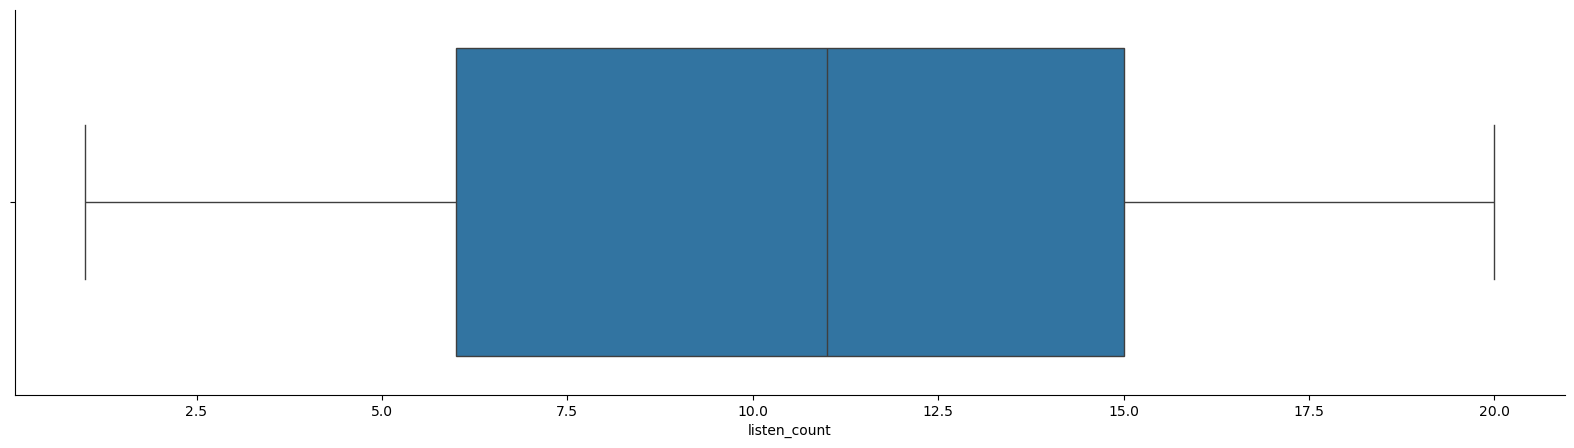

In [39]:
plt.figure(figsize=(20, 5))
sns.boxplot(x='listen_count', data=df_songs)
sns.despine()

In [40]:
listen_counts_temp = listen_counts[listen_counts['count'] > 50].reset_index(drop=False)

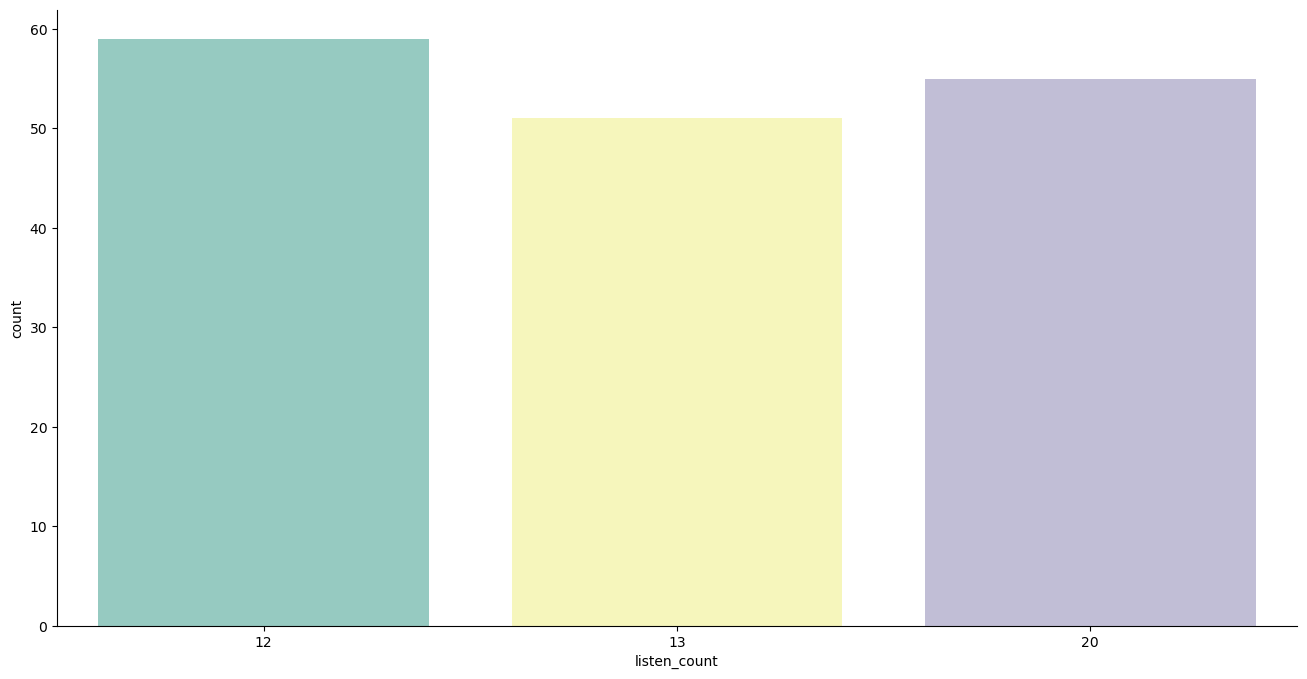

In [41]:
plt.figure(figsize=(16, 8))
sns.barplot(x='listen_count', y='count', palette='Set3', data=listen_counts_temp)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

In [42]:
song_user = df_songs.groupby('user_id')['song_id'].count()

C:\Users\yamun\AppData\Local\Temp\ipykernel_12844\2530348831.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(song_user.values, color='orange')


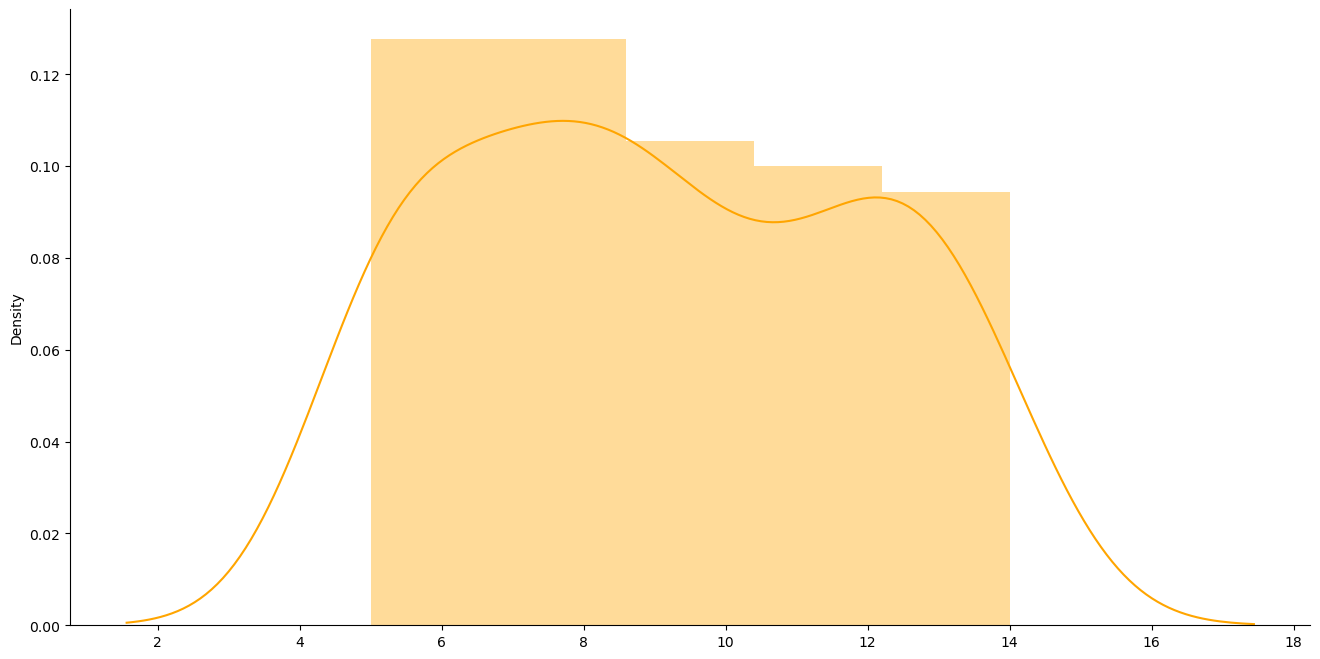

In [43]:
plt.figure(figsize=(16, 8))
sns.distplot(song_user.values, color='orange')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

In [44]:
print(f"A user listens to an average of {np.mean(song_user)} songs")

A user listens to an average of 9.12 songs


In [45]:
print(f"A user listens to an average of {np.median(song_user)} songs, with minimum {np.min(song_user)} and maximum {np.max(song_user)} songs")

A user listens to an average of 9.0 songs, with minimum 5 and maximum 14 songs


In [46]:
# Get how many values should it be if all songs have been listen by all users
values_matrix = unique_users * unique_songs

In [47]:
# Substract the total values with the actural shape of the DataFrame songs
zero_values_matrix = values_matrix - df_songs.shape[0]

In [48]:
print(f"The matrix of users x songs has {zero_values_matrix} values that are zero")

The matrix of users x songs has 4088 values that are zero


In [49]:
# Get users which have listen to at least 16 songs
song_ten_id = song_user[song_user > 16].index.to_list()

In [50]:
# Filtered the dataset to keep only those users with more than 16 listened
df_song_id_more_ten = df_songs[df_songs['user_id'].isin(song_ten_id)].reset_index(drop=True)

In [51]:
# convert the dataframe into a pivot table
df_songs_features = df_song_id_more_ten.pivot(index='song_id', columns='user_id', values='listen_count').fillna(0)

# obtain a sparse matrix
mat_songs_features = csr_matrix(df_songs_features.values)

In [52]:
df_songs_features.head()

user_id
song_id


In [53]:
df_unique_songs = df_songs.drop_duplicates(subset=['song_id']).reset_index(drop=True)[['song_id', 'title']]

In [54]:
decode_id_song = {
    song: i for i, song in 
    enumerate(list(df_unique_songs.set_index('song_id').loc[df_songs_features.index].title))
}

In [56]:
print(songs.shape)
print(songs.head())


(912, 5)
  user_id  song_id  listen_count     title artist_name
0  user_1  song_23            17  Title 23   Artist 13
1  user_1  song_26             4  Title 26    Artist 3
2  user_1  song_46            16  Title 46   Artist 12
3  user_1  song_30             3  Title 30    Artist 3
4  user_1  song_43            20  Title 43   Artist 13


In [57]:
from scipy.sparse import csr_matrix

# Create a matrix with songs as rows and users as columns
song_user_pivot = songs.pivot_table(index='title', columns='user_id', values='listen_count', fill_value=0)

# Convert to sparse matrix
mat_songs_features = csr_matrix(song_user_pivot.values)

# Create decode_id_song: song title -> index in matrix
decode_id_song = {title: i for i, title in enumerate(song_user_pivot.index)}


In [58]:
model = Recommender(metric='cosine', algorithm='brute', k=20, data=mat_songs_features, decode_id_song=decode_id_song)


In [59]:
song = "Title 23"  # Use a valid song title
recommendations = model.make_recommendation(new_song=song, n_recommendations=5)

print(f"\nTop recommendations for '{song}':")
for idx, title in enumerate(recommendations, start=1):
    print(f"{idx}. {title}")


Starting the recommendation process for Title 23 ...
... Done

Top recommendations for 'Title 23':
1. Title 44
2. Title 41
3. Title 32
4. Title 43
5. Title 39
